# E7 - Decision Trees - Bagging

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [71]:
# Librerías

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegressionCV

from tabulate import tabulate

# Parte 1 - Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [72]:
# read the data and set "datetime" as the index
bikes = pd.read_csv('Dataset/bikeshare.csv', index_col='datetime', parse_dates=True)

# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

# create "hour" as its own feature
bikes['hour'] = bikes.index.hour
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [73]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [74]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [75]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

<AxesSubplot:xlabel='hour'>

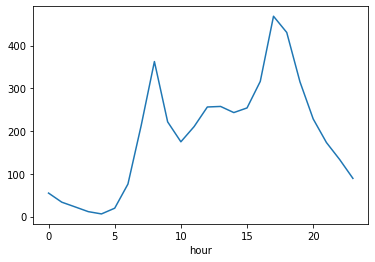

In [76]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

In [77]:
# hourly rental trend for "workingday=0"


In [78]:
# hourly rental trend for "workingday=1"


In [79]:
# combine the two plots


Write about your findings

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

# Parte 2 - Bagging

## Mashable news stories analysis

Predicting if a news story is going to be popular

In [80]:
df = pd.read_csv('Dataset/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [81]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [82]:
y.describe()

count    6000.000000
mean        0.500000
std         0.500042
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Popular, dtype: float64

In [83]:
X.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,358.138833,10.368667,547.428833,0.527732,0.961333,0.665823,11.874000,3.272500,4.954667,1.463167,...,0.357497,0.097194,0.762009,-0.265334,-0.530531,-0.110047,0.296854,0.077178,0.343496,0.167633
std,210.734614,2.106140,510.232776,0.148356,0.192815,0.167740,13.444103,4.262895,8.635916,4.508144,...,0.112586,0.076585,0.256845,0.133800,0.294477,0.100482,0.334117,0.282790,0.186815,0.240462
min,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,175.000000,9.000000,231.000000,0.465950,1.000000,0.619624,4.000000,1.000000,1.000000,0.000000,...,0.308693,0.050000,0.600000,-0.340000,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,345.000000,10.000000,391.000000,0.541477,1.000000,0.689119,8.000000,2.000000,1.000000,0.000000,...,0.364237,0.100000,0.800000,-0.260185,-0.500000,-0.100000,0.200000,0.000000,0.500000,0.016667
75%,544.250000,12.000000,719.000000,0.614980,1.000000,0.756237,15.000000,4.000000,7.000000,1.000000,...,0.419669,0.100000,1.000000,-0.191273,-0.300000,-0.050000,0.500000,0.166667,0.500000,0.250000
max,731.000000,19.000000,8474.000000,0.967742,1.000000,1.000000,304.000000,116.000000,111.000000,91.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [84]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Train vs test
table = [[y_train.describe(), y_test.describe()[-0]]]
headers = ['Train', 'Test']
print(tabulate(table,headers))

Train                            Test
-----------------------------  ------
count    4500.000000             1500
mean        0.502444
std         0.500050
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Popular, dtype: float64


# Exercise 7.6

Estimate a Decision Tree Classifier and a Logistic Regression

Evaluate using the following metrics:
* Accuracy
* F1-Score

### i) Árbol de Decisión

In [85]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

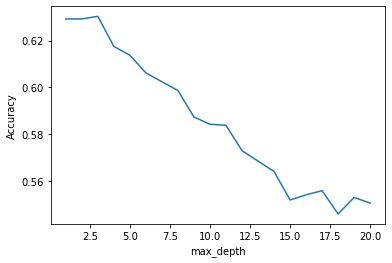

In [86]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [87]:
# show the best accuracy and the corresponding max_depth
tunning=sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
print("Best accuracy",tunning[0])
print("Max Depth",tunning[1])

Best accuracy 0.6304444444444444
Max Depth 3


In [88]:
# once best max_depth is selected, so fit a tree using that parameter
clf = DecisionTreeClassifier(max_depth=tunning[1], random_state=123)
accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [89]:
# compute feature importances
feature_cols = X.columns[X.columns.str.startswith('C') == False]

pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance',ascending=False).head(10)

,feature,importance
26,kw_avg_avg,0.719798
21,kw_min_max,0.104722
25,kw_max_avg,0.090037
20,kw_avg_min,0.049868
23,kw_avg_max,0.035574
0,timedelta,0.000000
32,weekday_is_wednesday,0.000000
34,weekday_is_friday,0.000000
35,weekday_is_saturday,0.000000
36,weekday_is_sunday,0.000000


In [90]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)

# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.462667
std         0.500113           std         0.498771
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [91]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[522, 239],
       [284, 455]])

In [92]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6513333333333333
F1 score: 0.6350314026517794
Precision: 0.6556195965417867
Recall: 0.6156968876860622


### ii) Regresión Logistica

In [93]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# predict
y_pred=logreg.predict(X_test)

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[501, 260],
       [258, 481]])

In [95]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6546666666666666
F1 score: 0.6500000000000001
Precision: 0.6491228070175439
Recall: 0.6508795669824087


# Exercise 7.7

i) Estimate 300 bagged samples

### 300 bagged samples

In [96]:
# set a seed for reproducibility
seed=np.random.seed(123)

# number of bagged samples
B=300

# model
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=B, 
                          bootstrap=True, oob_score=True, random_state=seed)

# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred=pd.DataFrame(y_pred)

In [97]:
# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.497867
std         0.500113           std         0.175126
min         0.000000           min         0.026667
25%         0.000000           25%         0.376667
50%         0.000000           50%         0.503333
75%         1.000000           75%         0.626667
max         1.000000           max         0.930000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [98]:
# calculate RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

0.46052597948191565

ii) Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

### 100 Decision Trees where max_depth=None

In [99]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [100]:
# show the rows for the first decision tree
y_train.iloc[samples[0]]

3444    1
1307    0
2007    1
4756    1
1655    1
       ..
3956    1
4065    0
5754    1
894     1
3647    0
Name: Popular, Length: 4500, dtype: int64

In [101]:
X_train.iloc[samples[0], :]

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
3444,408.0,12.0,93.0,0.725275,1.0,0.833333,5.0,4.0,1.0,1.0,...,0.442857,0.285714,0.60,-0.155556,-0.155556,-0.155556,0.000000,0.000000,0.500000,0.000000
1307,717.0,12.0,294.0,0.680851,1.0,0.863636,15.0,0.0,1.0,0.0,...,0.339336,0.050000,0.70,-0.497222,-1.000000,-0.155556,0.100000,0.050000,0.400000,0.050000
2007,198.0,10.0,191.0,0.545455,1.0,0.524390,4.0,4.0,15.0,0.0,...,0.739394,0.136364,1.00,-0.355556,-0.433333,-0.200000,0.000000,0.000000,0.500000,0.000000
4756,620.0,8.0,1055.0,0.427488,1.0,0.639794,15.0,0.0,1.0,0.0,...,0.381169,0.033333,0.90,-0.208165,-0.600000,-0.050000,0.000000,0.000000,0.500000,0.000000
1655,422.0,11.0,468.0,0.502262,1.0,0.623693,31.0,5.0,26.0,1.0,...,0.473333,0.200000,1.00,-0.360195,-0.800000,-0.071429,0.800000,0.400000,0.300000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,155.0,11.0,880.0,0.393728,1.0,0.563126,12.0,1.0,1.0,1.0,...,0.443021,0.100000,1.00,-0.149074,-0.250000,-0.050000,0.394444,-0.046528,0.105556,0.046528
4065,383.0,11.0,498.0,0.523614,1.0,0.661342,10.0,0.0,1.0,1.0,...,0.260341,0.100000,0.85,-0.273333,-0.600000,-0.100000,0.275000,0.068182,0.225000,0.068182
5754,526.0,5.0,1067.0,0.361987,1.0,0.508689,11.0,3.0,9.0,0.0,...,0.346914,0.100000,1.00,-0.176667,-0.500000,-0.050000,0.300000,1.000000,0.200000,1.000000
894,156.0,11.0,999.0,0.436052,1.0,0.672348,9.0,0.0,1.0,0.0,...,0.336712,0.050000,0.90,-0.311995,-1.000000,-0.100000,0.300000,0.100000,0.200000,0.100000


In [102]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_tree = X_train.iloc[samples[i], :]
    y_train_tree = y_train.iloc[samples[i]]
    treereg.fit(X_train_tree, y_train_tree)
    y_pred.append(treereg.predict(X_test))
    
y_pred = np.transpose(pd.DataFrame(y_pred))
y_pred

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [103]:
#Results of the ensemble
#y_pred_mean = y_pred.mean(axis=1)
y_pred_mean = (np.mean(y_pred, axis=1) >= 0.5).astype(np.int)
y_pred_mean

0       1
1       1
2       1
3       0
4       1
       ..
1495    0
1496    1
1497    0
1498    0
1499    0
Length: 1500, dtype: int64

In [104]:
# MSE
np.sqrt(mean_squared_error(y_test, y_pred_mean))

0.5796550698475775

### 100 Decision Trees where max_depth=2

In [105]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [106]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=2, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_tree = X_train.iloc[samples[i], :]
    y_train_tree = y_train.iloc[samples[i]]
    treereg.fit(X_train_tree, y_train_tree)
    y_pred.append(treereg.predict(X_test))

y_pred = np.transpose(pd.DataFrame(y_pred))
y_pred

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.412621,0.435723,0.431058,0.334364,0.445018,0.503704,0.429190,0.507395,0.459665,0.401493,...,0.438849,0.404867,0.405301,0.287321,0.515982,0.414365,0.566281,0.415706,0.293255,0.431415
1,0.412621,0.435723,0.431058,0.334364,0.445018,0.503704,0.429190,0.507395,0.459665,0.401493,...,0.438849,0.404867,0.405301,0.451145,0.303011,0.414365,0.566281,0.415706,0.455655,0.431415
2,0.577342,0.729400,0.698652,0.691348,0.719873,0.677800,0.295652,0.669519,0.579420,0.589255,...,0.741667,0.608789,0.675708,0.587473,0.576594,0.614301,0.566281,0.712302,0.726384,0.600420
3,0.412621,0.435723,0.431058,0.334364,0.266885,0.289928,0.429190,0.374625,0.459665,0.401493,...,0.297175,0.404867,0.405301,0.451145,0.303011,0.414365,0.471050,0.415706,0.455655,0.431415
4,0.730488,0.595928,0.538329,0.691348,0.572209,0.677800,0.637939,0.669519,0.726221,0.589255,...,0.603322,0.608789,0.512164,0.727825,0.738120,0.614301,0.725153,0.564648,0.726384,0.754453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.577342,0.595928,0.538329,0.546627,0.572209,0.503704,0.295652,0.507395,0.726221,0.589255,...,0.603322,0.608789,0.512164,0.587473,0.576594,0.614301,0.312950,0.564648,0.587255,0.600420
1496,0.577342,0.729400,0.698652,0.546627,0.719873,0.289928,0.637939,0.374625,0.726221,0.589255,...,0.603322,0.608789,0.675708,0.587473,0.576594,0.614301,0.471050,0.564648,0.587255,0.600420
1497,0.412621,0.435723,0.431058,0.334364,0.266885,0.289928,0.429190,0.374625,0.459665,0.401493,...,0.297175,0.404867,0.405301,0.451145,0.303011,0.414365,0.471050,0.415706,0.455655,0.431415
1498,0.209354,0.435723,0.431058,0.334364,0.445018,0.503704,0.246020,0.507395,0.295833,0.401493,...,0.438849,0.213808,0.198830,0.287321,0.303011,0.414365,0.566281,0.204900,0.293255,0.208920


In [107]:
#Results of the ensemble
#y_pred_mean = y_pred.mean(axis=1)
y_pred_mean = (np.mean(y_pred, axis=1) >= 0.5).astype(np.int)
y_pred_mean

0       0
1       0
2       1
3       0
4       1
       ..
1495    1
1496    1
1497    0
1498    0
1499    0
Length: 1500, dtype: int64

In [108]:
# MSE
np.sqrt(mean_squared_error(y_test, y_pred_mean))

0.5904800307094785

### 100 logistic regression

In [109]:
np.random.seed(123) 
n_estimators = 100

seeds = np.random.randint(1, 10000, size=n_estimators)
n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# create
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    X_train_2[i] = trees[i].predict(X_train)

X_train_2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4936,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
761,1,0,0,0,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,0
4281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,1,0
5579,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,1
3653,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4060,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1346,1,0,1,1,0,1,0,1,0,1,...,1,0,0,1,1,0,1,1,1,1
3454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [110]:
lr = LogisticRegressionCV(cv = 5 )
lr.fit(X_train_2, y_train)

lr.coef_

array([[0.03439087, 0.03400682, 0.03525004, 0.03487362, 0.03510432,
        0.03492571, 0.0352141 , 0.0354671 , 0.03509776, 0.03505057,
        0.03468621, 0.03318939, 0.03501431, 0.03443667, 0.03500061,
        0.03567682, 0.03433451, 0.03541803, 0.03469722, 0.03493   ,
        0.03496626, 0.03440055, 0.03436068, 0.03492462, 0.03400025,
        0.03518369, 0.03430051, 0.03429122, 0.03369941, 0.03581459,
        0.03391153, 0.0351802 , 0.03472354, 0.03510402, 0.03597604,
        0.03524208, 0.03456946, 0.03519206, 0.03470044, 0.03496483,
        0.03504765, 0.03495937, 0.0345851 , 0.03511182, 0.03504363,
        0.03420868, 0.03510403, 0.03574659, 0.03538845, 0.03503334,
        0.03404426, 0.03441885, 0.03503623, 0.0339724 , 0.03512012,
        0.03500518, 0.03474991, 0.03590856, 0.03469649, 0.03554311,
        0.03450086, 0.03443209, 0.03423249, 0.03447997, 0.03391461,
        0.03483489, 0.03602916, 0.03592495, 0.03452854, 0.03556976,
        0.03456459, 0.03553566, 0.03459509, 0.03

# Exercise 7.8

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [111]:
# set a seed for reproducibility
seed=np.random.seed(123)

# number of bagged samples
B=300

# model
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

# fit and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)

In [112]:
# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.507333
std         0.500113           std         0.500113
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         1.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [113]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6613333333333333
F1 score: 0.6613333333333333
Precision: 0.6517739816031537
Recall: 0.6711772665764547


# Exercise 7.9

i) Estimate the probability as %models that predict positive

In [114]:
y_pred.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,,
1,761,0.507333
0,739,0.492667


ii) Modify the probability threshold and select the one that maximizes the F1-Score

# Exercise 7.10

Ensemble using weighted voting using the oob_error

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [115]:
# set a seed for reproducibility
seed=np.random.seed(123)

# number of bagged samples
B=300

# model
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

# fit and predict
clf.fit(X_train, y_train)
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
y_pred=pd.DataFrame(y_pred)

In [116]:
# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.513333
std         0.500113           std         0.499989
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         1.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [117]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6646666666666666
F1 score: 0.6666666666666667
Precision: 0.6532467532467533
Recall: 0.6806495263870095


# Exercise 7.11

i) Estimate the probability of the weighted voting

In [118]:
y_pred.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,,
1,770,0.513333
0,730,0.486667


ii) Modify the probability threshold and select the one that maximizes the F1-Score

# Exercise 7.12

i) Estimate a logistic regression using as input the estimated classifiers

ii) Modify the probability threshold such that maximizes the F1-Score